In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

import autograd
from autograd import numpy as np
from autograd import scipy as sp

import numpy as onp
import scipy as osp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Set up model

In [2]:
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha8.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Experimenting w GH points

In [4]:
# Refit with more GH points
gh_deg = 20

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=model.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.252659819113031	 Objective: -305.35833030090663
Iter: 1	 RMSE: 11.252659791490329	 Objective: -305.35833030091084
Optimization terminated successfully.
         Current function value: -305.358330
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. 


# Define perturbation

In [5]:
class InfluenceFunction(object): 
    def __init__(self, model, input_par, output_par, 
                         input_to_output_converter, 
                         optimal_input_par, 
                         objective_hessian): 
        
        self.null_perturbation = fun_sens_lib.PriorPerturbation(model, lambda x : 0.0 * x)
        self.null_perturbation.set_epsilon(0.0)
        
        self.optimal_input_par = optimal_input_par
        self.model = model
        
        self.sensitivity_object = \
            obj_lib.ParametricSensitivity(
                objective_fun=model.set_z_get_kl,
                input_par=input_par,
                output_par=output_par,
                hyper_par=self.null_perturbation.epsilon_param,
                input_to_output_converter=input_to_output_converter,
                optimal_input_par=optimal_input_par,
                objective_hessian=objective_hessian,
                hyper_par_objective_fun=None)
        
        # this is grad log q
        self.jac_q_logit_sticks = autograd.jacobian(self.get_q_logit_stick_from_free_params, argnum=0)
        
        # this is g_eta H^{-1}
        # should a matrix of size len(output_par) x len(global_free_par)
        self.influence_operator = osp.linalg.cho_solve(self.sensitivity_object.hessian_chol, 
                                                       self.sensitivity_object.dout_din.T).T
        
    def get_log_ratio(self, logit_v, k): 
        # this is log(q / p_0) in logit space
        self.null_perturbation.model.global_vb_params.set_free(self.optimal_input_par)
        return -self.null_perturbation.get_log_p0_logit(logit_v) + \
                    self.null_perturbation.get_log_q_logit_stick(logit_v, k)
        
    def get_q_logit_stick_from_free_params(self, global_free_params, logit_v, k):
        self.null_perturbation.model.global_vb_params.set_free(global_free_params)

        return self.null_perturbation.get_log_q_logit_stick(logit_v, k)
    
    def get_jac_q_logit_sticks(self, logit_v, k): 
        # this returns grad log q 
        # returns a matrix of size len(global_free_params) x len(logit_v) 
        return self.jac_q_logit_sticks(self.optimal_input_par, logit_v, k).T
    
    def get_influence_function_k(self, logit_v, k): 
        return np.dot(self.influence_operator, self.get_jac_q_logit_sticks(logit_v, k)) * \
                    np.exp(self.get_log_ratio(logit_v, k))
        
    def get_influence_function(self, logit_v): 
        influence_fun = 0.0
        
        for k in range(self.model.k_approx - 1): 
            influence_fun = influence_fun + self.get_influence_function_k(logit_v, k)
            
        return influence_fun.squeeze()

#         log_influence_fun_array = np.zeros((self.model.k_approx - 1, len(logit_v)))
        
#         for k in range(self.model.k_approx - 1): 
#             log_influence_fun_array[k, :] = self.get_influence_function_k(logit_v, k)
            
#         return osp.misc.logsumexp(log_influence_fun_array, axis = 0)

In [6]:
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

influence_class = InfluenceFunction(model, 
                        input_par = e_num_clusters_class.model.global_vb_params, 
                        output_par = e_num_clusters_class.e_num_clusters, 
                        input_to_output_converter = e_num_clusters_class.set_e_num_clusters, 
                        optimal_input_par = best_param_0,
                        objective_hessian = kl_hessian_0)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [7]:
logit_theta = np.linspace(-10, 10, 100)

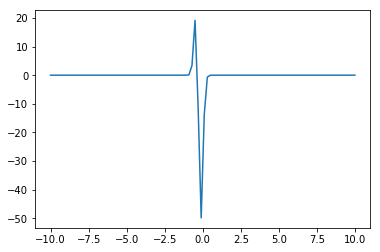

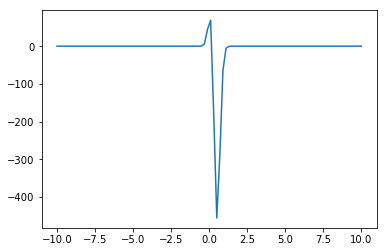

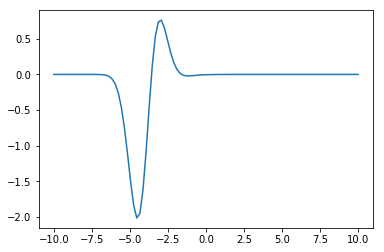

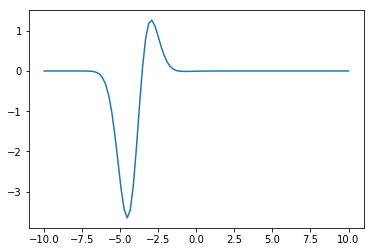

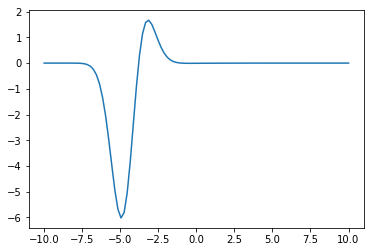

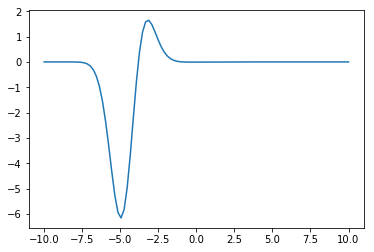

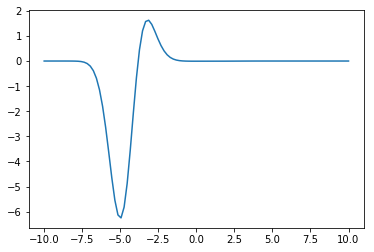

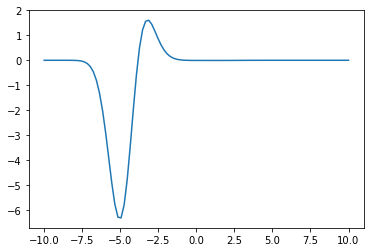

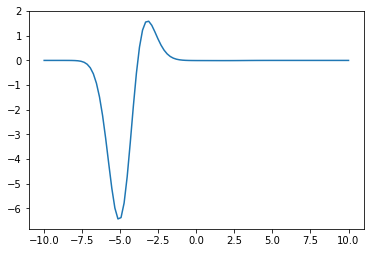

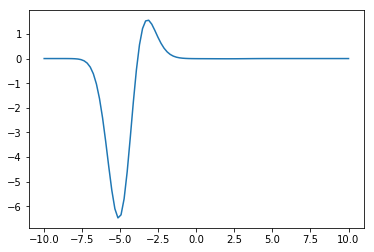

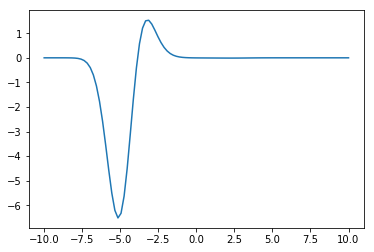

In [8]:
for k in range(model.k_approx - 1): 
    plt.figure()
    plt.plot(logit_theta, influence_class.get_influence_function_k(logit_theta, k).squeeze())

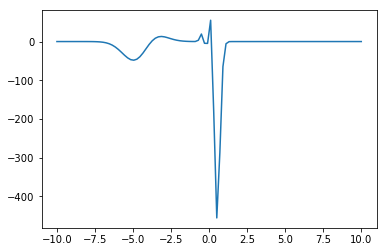

In [9]:
plt.plot(logit_theta, influence_class.get_influence_function(logit_theta))

In [10]:
import interpolation_lib as interp_lib

In [11]:
x_reg = np.linspace(-10, 10, 100)
knot_vector = x_reg
order = 3

In [12]:
logit_influence_fun_interp = interp_lib.BsplineRegression(influence_class.get_influence_function, 
                                                          x_reg, knot_vector, order)

condition number:  8.91187815224694


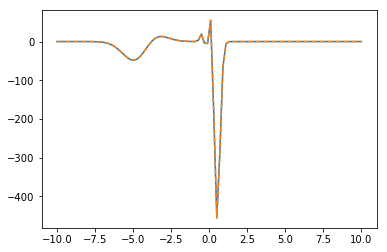

In [13]:
plt.plot(logit_theta, logit_influence_fun_interp.eval_fun(logit_theta))
plt.plot(logit_theta, logit_influence_fun_interp.eval_interp_fun(logit_theta), '--')

In [14]:
x_test = np.random.rand(1000) * 20 - 10

true_fun = logit_influence_fun_interp.eval_fun(x_test)
interp_fun = logit_influence_fun_interp.eval_interp_fun(x_test)

np.max(np.abs(true_fun - interp_fun) / np.abs(true_fun + 1e-8))

13.42408899371648

In [15]:
theta = np.linspace(0.0000001, 0.9999999, 1000)

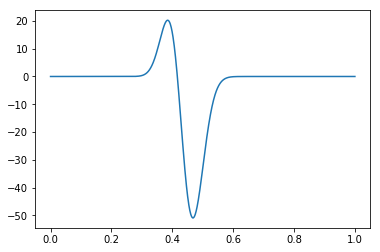

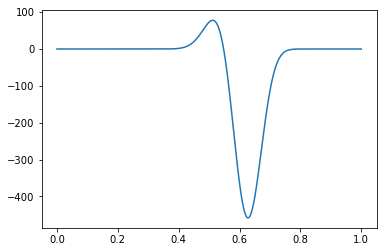

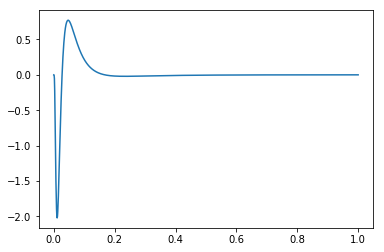

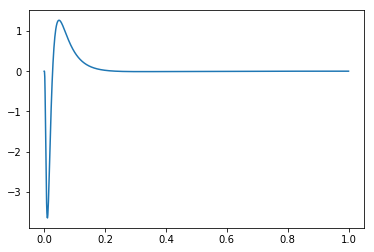

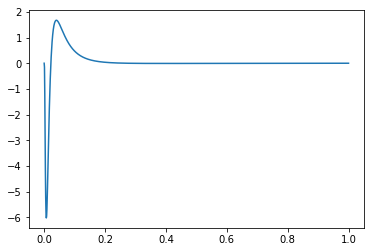

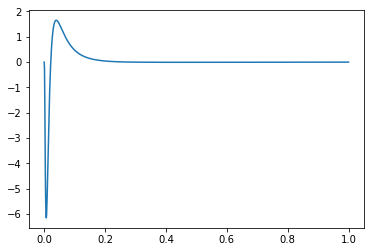

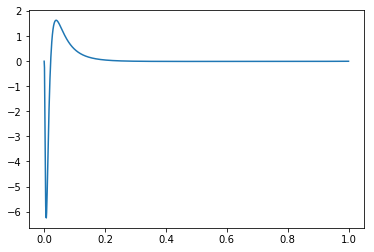

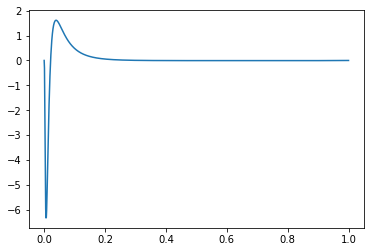

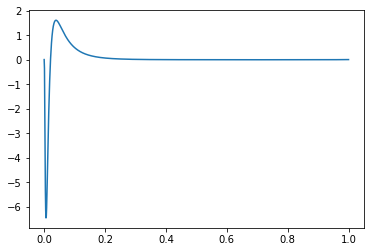

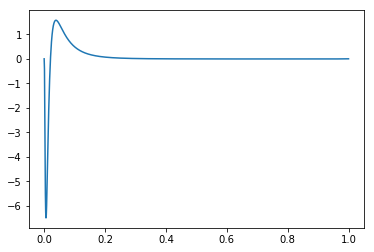

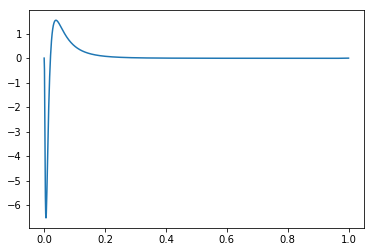

In [16]:
for k in range(model.k_approx - 1): 
    plt.figure()
    plt.plot(theta, influence_class.get_influence_function_k(sp.special.logit(theta), k).squeeze())

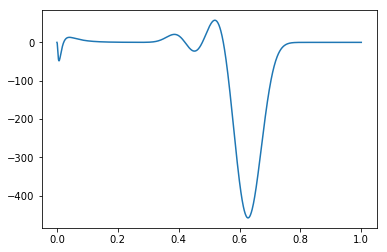

In [17]:
plt.plot(theta, influence_class.get_influence_function(sp.special.logit(theta)).squeeze())

In [18]:
# Define a perturbation in the logit v space.

# phi_center = -2
# #phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
# phi_log_rescale = -np.log(0.5)
# print(phi_log_rescale)

# def log_phi(logit_v):
#     return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))
# prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi)
# print(
#     prior_perturbation.log_norm_p0,
#     prior_perturbation.log_norm_pc,
#     prior_perturbation.log_norm_p0_logit,
#     prior_perturbation.log_norm_pc_logit)

In [19]:
def log_phi(logit_v): 
    return np.log(np.maximum(-logit_influence_fun_interp.eval_interp_fun(logit_v), 1e-12))

In [20]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, 
                                                    log_phi = log_phi,
                                                    logit_v_ub = 10,
                                                    logit_v_lb = -10)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.683014e-01
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.038237e-01
  AccuracyWarning)


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.683014e-01
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.038237e-01
  AccuracyWarning)


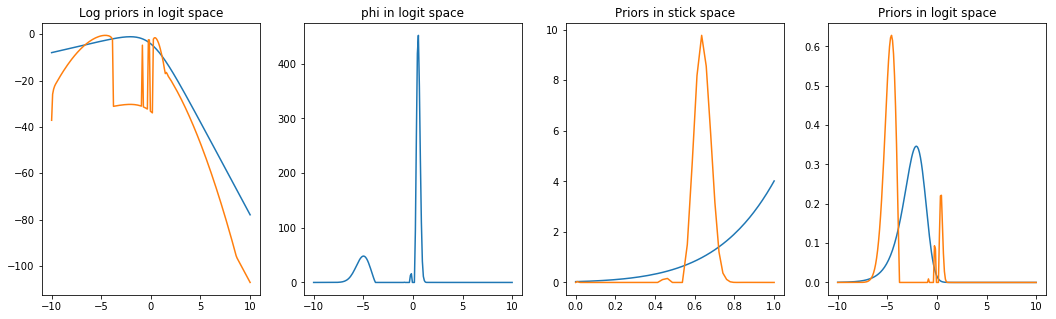

In [22]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                           prior_perturbation.logit_v_ub, 
                           200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [24]:
# This expects the hyperparameter to be at its optimal value.
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [25]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

45.245210169376044

# Fit with perturbation

In [26]:
epsilon = 0.2 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  0.2
Predicted differences:  9.049042033875207


In [27]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)
print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.018243e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.074874e-01
  AccuracyWarning)


epsilon: 0.2
Iter  0  value:  -264.62873826013896
Iter  1  value:  -269.18476375643024
Iter  2  value:  -273.98788387765177
Iter  3  value:  -275.23096851566464
Iter  4  value:  -278.58007809913767
Iter  5  value:  -281.0609477584884
Iter  6  value:  -281.11199506562974
Iter  7  value:  -281.19001953588855
Iter  8  value:  -281.32609133411927
Iter  9  value:  -283.4306608265473
Iter  10  value:  -283.6770718309848
Iter  11  value:  -283.91994477118374
Iter  12  value:  -284.1722167512835
Iter  13  value:  -284.23740180056376
Iter  14  value:  -284.2619804897705
Iter  15  value:  -284.3325909983016
Iter  16  value:  -284.3371638109692
Iter  17  value:  -284.3373529514667
Iter  18  value:  -284.33735435067354
Iter  19  value:  -284.33735435188436
Optimization terminated successfully.
         Current function value: -284.337354
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 0
Iter  20  value:  -284.33735435188464


In [28]:
# Get e_num_clusters before and after perturbation
output_phi = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi)
output_0 = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_0)

# Check results

Epsilon: 0.2


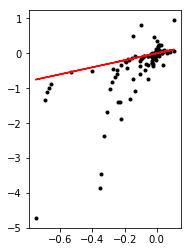

In [29]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [30]:
output_0

array([8.5190059])

In [31]:
output_phi 

array([7.33249184])

In [32]:
output_phi_pred

array([5.24958577])

# Fit with range of perturbations

In [39]:
# epsilon_vec = np.linspace(0.1, 1.0, 4)
epsilon_vec = np.linspace(0.02, 0.2, 10)
print(epsilon_vec)

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


In [40]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [41]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('Epsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
        epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

    output_phi = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi)

    print('Done. Converged: ', converged)

    print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    

Epsilon:  0.02
Predicted differences:  0.9049042033875209
epsilon: 0.02


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.933930e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.641464e-02
  AccuracyWarning)


Iter  249  value:  -302.26107108599746
Iter  250  value:  -302.31824825361485
Iter  251  value:  -302.17916887564996
Iter  252  value:  -302.32541586371235
Iter  253  value:  -302.32653295090137
Iter  254  value:  -302.32673563862414
Iter  255  value:  -302.32677625605834
Iter  256  value:  -302.3268194148183
Iter  257  value:  -302.32683504268533
Iter  258  value:  -302.3268359403543
Iter  259  value:  -302.32683594144794
Optimization terminated successfully.
         Current function value: -302.326836
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 10
         Hessian evaluations: 0
Iter  260  value:  -302.3268359414466
Iter  261  value:  -302.3268359414486
         Current function value: -302.326836
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 0.2972913746085874
Epsilon:  0.04000000000000001
Predicted diffe

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.371475e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.846353e-02
  AccuracyWarning)


Iter  262  value:  -299.2726164035876
Iter  263  value:  -299.25518965645466
Iter  264  value:  -299.38610514133296
Iter  265  value:  -299.22785184012014
Iter  266  value:  -299.43082144223445
Iter  267  value:  -299.43087957809126
Iter  268  value:  -299.48806745229757
Iter  269  value:  -299.52623481527
Iter  270  value:  -299.5285087249297
Iter  271  value:  -299.5347390983566
Iter  272  value:  -299.53724147412635
Iter  273  value:  -299.55001057206863
Iter  274  value:  -299.5503987716373
Iter  275  value:  -299.5507870271014
Iter  276  value:  -299.55117527026994
Iter  277  value:  -299.55156298995496
Iter  278  value:  -299.5519476558914
Iter  279  value:  -299.55231828430107
Iter  280  value:  -299.55263368188037
Iter  281  value:  -299.5528218986439
Iter  282  value:  -299.55286868235316
Iter  283  value:  -299.5528705457182
Iter  284  value:  -299.5528705476932
Optimization terminated successfully.
         Current function value: -299.552871
         Iterations: 22
        

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.379486e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.227938e-02
  AccuracyWarning)


Iter  287  value:  -296.08670586780164
Iter  288  value:  -296.8610166662694
Iter  289  value:  -296.3978665332935
Iter  290  value:  -296.9886313038995
Iter  291  value:  -297.05910426642475
Iter  292  value:  -297.08318190764885
Iter  293  value:  -297.08538967687406
Iter  294  value:  -297.0859325344669
Iter  295  value:  -297.0859432708234
Iter  296  value:  -297.08594331949547
Iter  297  value:  -297.08594331951224
Optimization terminated successfully.
         Current function value: -297.085943
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 10
         Hessian evaluations: 0
Iter  298  value:  -297.08594331951355
Iter  299  value:  -297.08594331951235
         Current function value: -297.085943
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.2498566843393024
Epsilon:  0.08000000000000002
Predicted differ

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.566045e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.139250e-02
  AccuracyWarning)


Iter  300  value:  -293.66734031879884
Iter  301  value:  -294.5581622635324
Iter  302  value:  -295.18259761423917
Iter  303  value:  -295.19672635098607
Iter  304  value:  -295.2113851463642
Iter  305  value:  -295.229365419269
Iter  306  value:  -295.46051421863143
Iter  307  value:  -295.4747991804147
Iter  308  value:  -295.5094501992007
Iter  309  value:  -295.52580302703166
Iter  310  value:  -295.53519455842155
Iter  311  value:  -295.53876196672564
Iter  312  value:  -295.53920445232035
Iter  313  value:  -295.5392227426786
Iter  314  value:  -295.5392231978005
Iter  315  value:  -295.5392231981702
Optimization terminated successfully.
         Current function value: -295.539223
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
         Hessian evaluations: 0
Iter  316  value:  -295.5392231981722
Iter  317  value:  -295.539223198171
         Current function value: -295.539223
         Iterations: 0
         Function evaluations: 2
  

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.275361e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.783578e-02
  AccuracyWarning)


Iter  318  value:  -291.53308926764976
Iter  319  value:  -292.7484466252819
Iter  320  value:  -294.138229012411
Iter  321  value:  -292.27040355407905
Iter  322  value:  -294.395122107156
Iter  323  value:  -294.4225346644767
Iter  324  value:  -294.483733312576
Iter  325  value:  -294.53553808677464
Iter  326  value:  -294.54939061134417
Iter  327  value:  -294.5534154466453
Iter  328  value:  -294.55393206190246
Iter  329  value:  -294.55397851045535
Iter  330  value:  -294.55399487070036
Iter  331  value:  -294.5539955366161
Iter  332  value:  -294.55399556455467
Iter  333  value:  -294.55399556459474
Optimization terminated successfully.
         Current function value: -294.553996
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 14
         Hessian evaluations: 0
Iter  334  value:  -294.55399556459594
Iter  335  value:  -294.5539955645964
         Current function value: -294.553996
         Iterations: 0
         Function evaluations: 2
 

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.699880e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.278056e-02
  AccuracyWarning)


Iter  336  value:  -289.43442362679144
Iter  337  value:  -291.20699173054373
Iter  338  value:  -291.8804597480407
Iter  339  value:  -292.4288816040471
Iter  340  value:  -292.7941744309751
Iter  341  value:  -293.9054911098057
Iter  342  value:  -293.94949660469734
Iter  343  value:  -293.82847304213175
Iter  344  value:  -294.04958669312896
Iter  345  value:  -294.1613938665149
Iter  346  value:  -294.1794094714772
Iter  347  value:  -294.1922668258257
Iter  348  value:  -294.1961028474349
Iter  349  value:  -294.1965738458141
Iter  350  value:  -294.19658060177755
Iter  351  value:  -294.19658060348274
Optimization terminated successfully.
         Current function value: -294.196581
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 15
         Hessian evaluations: 0
Iter  352  value:  -294.19658060348183
Iter  353  value:  -294.1965806034825
Optimization terminated successfully.
         Current function value: -294.196581
         Iteration

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.944752e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.690251e-02
  AccuracyWarning)


Iter  354  value:  -284.89099453449046
Iter  355  value:  -287.6425722012155
Iter  356  value:  -290.05010431148503
Iter  357  value:  -289.7567076303906
Iter  358  value:  -291.4509713069737
Iter  359  value:  -291.9167944234215
Iter  360  value:  -292.05236860753286
Iter  361  value:  -292.35601192652433
Iter  362  value:  -292.40515566936466
Iter  363  value:  -292.41757736615284
Iter  364  value:  -292.453176669905
Iter  365  value:  -292.4593683207413
Iter  366  value:  -292.46020230945436
Iter  367  value:  -292.4602119300095
Iter  368  value:  -292.4602119350357
Optimization terminated successfully.
         Current function value: -292.460212
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 14
         Hessian evaluations: 0
Iter  369  value:  -292.46021193503566
Iter  370  value:  -292.46021193503583
Optimization terminated successfully.
         Current function value: -292.460212
         Iterations: 1
         Function evaluations: 2


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.064901e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.005922e-01
  AccuracyWarning)


Iter  371  value:  -279.878508742029
Iter  372  value:  -282.6282890445449
Iter  373  value:  -286.4125939477332
Iter  374  value:  -287.2162861304915
Iter  375  value:  -287.63933226943243
Iter  376  value:  -288.15751561987395
Iter  377  value:  -284.6664817201447
Iter  378  value:  -288.26921162781116
Iter  379  value:  -288.34422736142085
Iter  380  value:  -288.3974793358959
Iter  381  value:  -288.4207047918855
Iter  382  value:  -288.4236696406826
Iter  383  value:  -288.4246018582626
Iter  384  value:  -288.4246750355389
Iter  385  value:  -288.4246776956701
Iter  386  value:  -288.42467771095494
Iter  387  value:  -288.42467771095994
Optimization terminated successfully.
         Current function value: -288.424678
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 16
         Hessian evaluations: 0
Iter  388  value:  -288.4246777109595
Iter  389  value:  -288.42467771096005
         Current function value: -288.424678
         Iterations:

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.086311e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.040763e-01
  AccuracyWarning)


Iter  390  value:  -273.77727407172335
Iter  391  value:  -276.8387158183613
Iter  392  value:  -281.2444573219717
Iter  393  value:  -283.81970668841115
Iter  394  value:  -283.9449606354164
Iter  395  value:  -284.9006998138628
Iter  396  value:  -285.4761513421021
Iter  397  value:  -285.5293498414559
Iter  398  value:  -285.9899919838473
Iter  399  value:  -286.17206755716506
Iter  400  value:  -286.24120789497624
Iter  401  value:  -286.31635881817436
Iter  402  value:  -286.36885418941415
Iter  403  value:  -286.3867598907818
Iter  404  value:  -286.3829041658318
Iter  405  value:  -286.3829041658318
Iter  406  value:  -286.3829041658318
Iter  407  value:  -286.3886633928237
Iter  408  value:  -286.3893180306543
Iter  409  value:  -286.38955925088106
Iter  410  value:  -286.38957140438765
Iter  411  value:  -286.38957161750074
Iter  412  value:  -286.38957161755667
Optimization terminated successfully.
         Current function value: -286.389572
         Iterations: 22
         

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.018243e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.074874e-01
  AccuracyWarning)


Iter  415  value:  -264.62873826013896
Iter  416  value:  -269.18476375643024
Iter  417  value:  -273.98788387765177
Iter  418  value:  -275.23096851566464
Iter  419  value:  -278.58007809913767
Iter  420  value:  -281.0609477584884
Iter  421  value:  -281.11199506562974
Iter  422  value:  -281.19001953588855
Iter  423  value:  -281.32609133411927
Iter  424  value:  -283.4306608265473
Iter  425  value:  -283.6770718309848
Iter  426  value:  -283.91994477118374
Iter  427  value:  -284.1722167512835
Iter  428  value:  -284.23740180056376
Iter  429  value:  -284.2619804897705
Iter  430  value:  -284.3325909983016
Iter  431  value:  -284.3371638109692
Iter  432  value:  -284.3373529514667
Iter  433  value:  -284.33735435067354
Iter  434  value:  -284.33735435188436
Optimization terminated successfully.
         Current function value: -284.337354
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 0
Iter  435  value:  -2

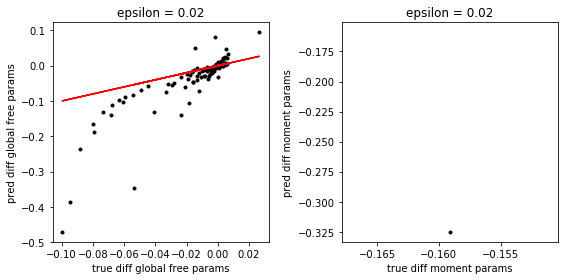

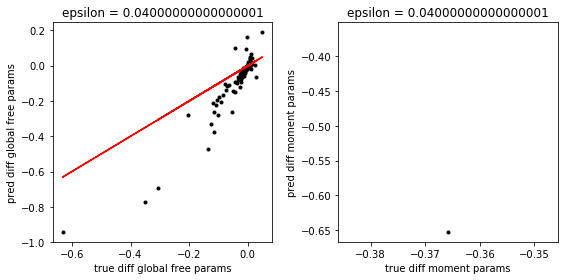

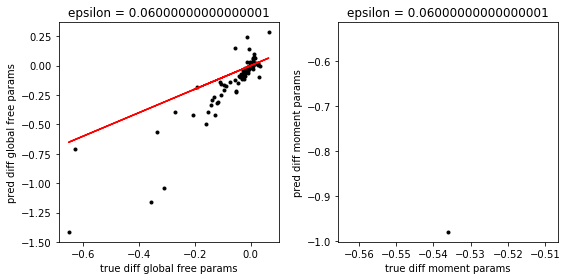

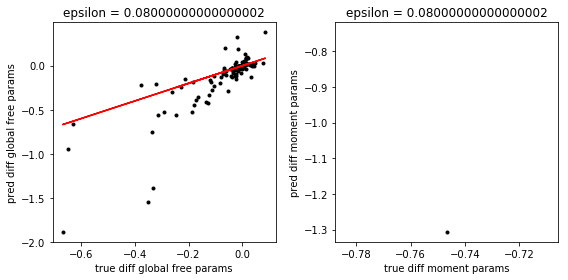

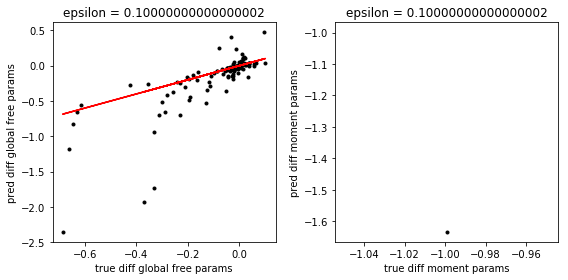

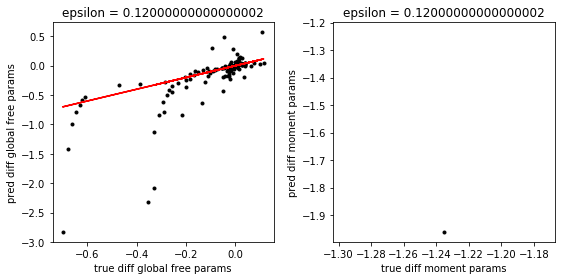

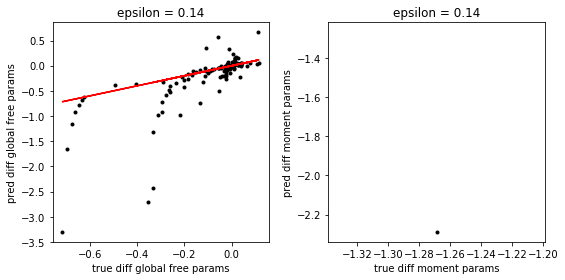

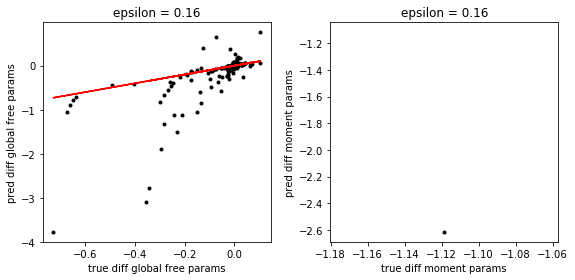

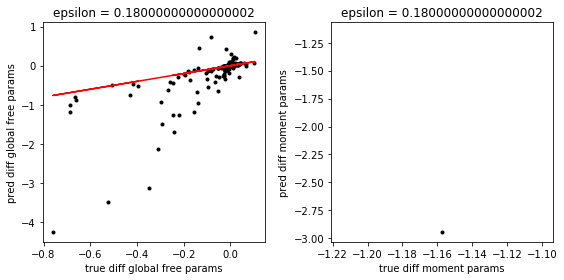

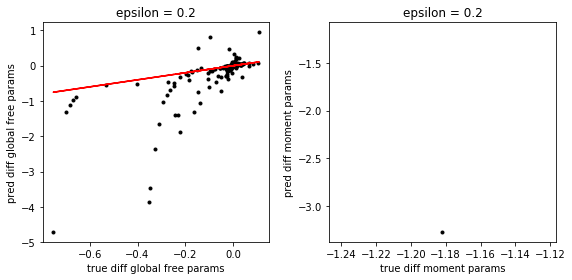

In [42]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_pred_array[i] - best_param_0, 'k.')
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_array[i] - best_param_0, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.subplot(1, 2, 2)
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_pred_array[i] - output_0, 'k.')
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_array[i] - output_0, 'r')
    plt.xlabel('true diff moment params')
    plt.ylabel('pred diff moment params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
    plt.tight_layout()

    

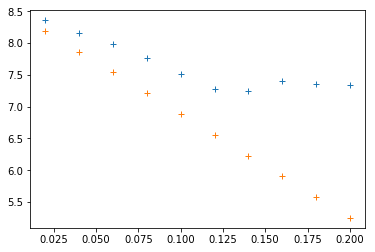

In [43]:
plt.plot(epsilon_vec, output_phi_array, '+')
plt.plot(epsilon_vec, output_phi_pred_array, '+')

In [44]:
output_phi_pred_nonlin_array = []
for i in range(len(epsilon_vec)): 
    output_phi_pred_nonlin_array.append(
        epsilon_sensitivity.predict_output_par_from_hyperparameters(epsilon_vec[i], linear = False))

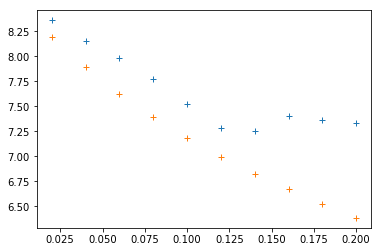

In [45]:
plt.plot(epsilon_vec, output_phi_array, '+')
plt.plot(epsilon_vec, output_phi_pred_nonlin_array, '+')